## Importing Libraries

In [1]:
import pandas as pd
import numpy as np
from time import time
from tensorflow.python.keras.callbacks import TensorBoard
import re

#from google.colab import drive
#drive.mount('/content/gdrive')
# Dataset is now stored in a Pandas Dataframe

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Importing Data

In [2]:
data=pd.read_csv('DonorsChoose_LSTM.csv')

In [60]:
data[101926:101927]

,teacher_prefix,school_state,project_grade_category,teacher_number_of_previously_posted_projects,project_is_approved,price,quantity,clean_essay,clean_title,clean_categories,clean_subcategories,Is_digit_present
101926,Ms.,FL,Grades 9-12,2,1,297.87,2,students sit talk discovered various nationali...,let illustrate,Music_Arts,VisualArts,0


In [11]:
data['total_text']=data['clean_essay'].map(str) + data['clean_title'].map(str)

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
train, test = train_test_split(data, random_state=123, shuffle=True, test_size=0.1)
print("Training data shape:", train.shape)
print("Test data shape:", test.shape)

Training data shape: (98323, 13)
Test data shape: (10925, 13)


In [13]:
train=train.reset_index()
test=test.reset_index()

In [14]:
train.head(2)

,index,teacher_prefix,school_state,project_grade_category,teacher_number_of_previously_posted_projects,project_is_approved,price,quantity,clean_essay,clean_title,clean_categories,clean_subcategories,Is_digit_present,total_text
0,101926,Ms.,FL,Grades 9-12,2,1,297.87,2,students sit talk discovered various nationali...,let illustrate,Music_Arts,VisualArts,0,students sit talk discovered various nationali...
1,83948,Mrs.,CA,Grades 3-5,0,1,194.93,11,imagine coming school every day knowing odds n...,rekindling science,Math_Science SpecialNeeds,EnvironmentalScience SpecialNeeds,0,imagine coming school every day knowing odds n...


## Distribution of positive and negative data points 

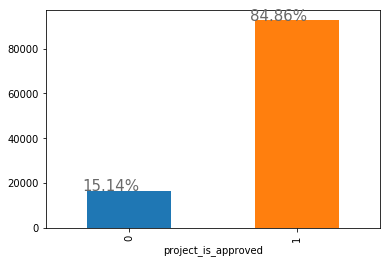

In [65]:
ax = data.groupby("project_is_approved")["project_is_approved"].count().plot.bar()

# create a list to collect the plt.patches data
totals = []

# find the values and append to list
for i in ax.patches:
    totals.append(i.get_height())

# set individual bar lables using above list
total = sum(totals)

# set individual bar lables using above list
for i in ax.patches:
    # get_x pulls left or right; get_height pushes up or down
    ax.text(i.get_x()-.03, i.get_height()+.5, \
            str(round((i.get_height()/total)*100, 2))+'%', fontsize=15,
                color='dimgrey')

## Importing pre trained Glove vectors

In [3]:
import io
import pickle
with io.open('glove_vectors.txt', 'rb') as f:
    glove_model = pickle.load(f)
    glove_words =  set(glove_model.keys())

## Preprocessing with Keras tokenizer

In [8]:
from keras.preprocessing.text import Tokenizer

Using TensorFlow backend.


In [9]:



token = Tokenizer()

token.fit_on_texts(train['total_text'])
train['total_text']=token.texts_to_sequences(train['total_text'])
test['total_text']=token.texts_to_sequences(test['total_text'])
text_size = len(token.word_index) + 1

# create a weight matrix for words in training docs --code copied from https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/
embedding_matrix = np.zeros((text_size, 300))
for word, i in token.word_index.items():
    embedding_vector = glove_model.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

token = Tokenizer()

token.fit_on_texts(train['clean_categories'])
train['clean_categories']=token.texts_to_sequences(train['clean_categories'])
test['clean_categories']=token.texts_to_sequences(test['clean_categories'])
category_size = len(token.word_index) + 1

token = Tokenizer()

token.fit_on_texts(train['teacher_prefix'])
train['teacher_prefix']=token.texts_to_sequences(train['teacher_prefix'])
test['teacher_prefix']=token.texts_to_sequences(test['teacher_prefix'])
prefix_size = len(token.word_index) + 1

token = Tokenizer()

token.fit_on_texts(train['school_state'])
train['school_state']=token.texts_to_sequences(train['school_state'])
test['school_state']=token.texts_to_sequences(test['school_state'])
state_size = len(token.word_index) + 1

token = Tokenizer()

token.fit_on_texts(train['project_grade_category'])
train['project_grade_category']=token.texts_to_sequences(train['project_grade_category'])
test['project_grade_category']=token.texts_to_sequences(test['project_grade_category'])
grade_size = len(token.word_index) + 1

token = Tokenizer()

token.fit_on_texts(train['clean_subcategories'])
train['clean_subcategories']=token.texts_to_sequences(train['clean_subcategories'])
test['clean_subcategories']=token.texts_to_sequences(test['clean_subcategories'])
subcategory_size = len(token.word_index) + 1

In [74]:
embedding_matrix.shape

(67062, 300)

In [75]:
train.drop(['clean_essay','clean_title','index'] , axis=1, inplace=True)
test.drop(['clean_essay','clean_title','index'] , axis=1, inplace=True)

In [10]:
train.tail(2)

,index,teacher_prefix,school_state,project_grade_category,teacher_number_of_previously_posted_projects,project_is_approved,price,quantity,clean_essay,clean_title,clean_categories,clean_subcategories,Is_digit_present,total_text
98321,28030,[2],[2],"[1, 2, 3]",1,1,471.0,15,best part teaching second grade hands enthusia...,reading learn non fiction,"[3, 4, 1, 2]","[10, 1]",0,"[30, 97, 95, 124, 50, 375, 28, 638, 814, 4, 19..."
98322,15725,[2],[18],"[1, 2, 3]",1,0,867.5,9,students mix special needs students thrive chi...,multimedia learning enhances communication,"[1, 2, 3, 4]","[1, 2]",0,"[973, 27, 459, 122, 836, 226, 3, 459, 4077, 42..."


## Getting data in the form of Dictionary which then will be given as a input to Deep Learning Models

In [13]:
from keras.preprocessing.sequence import pad_sequences
from numpy import array

In [78]:
X_train={}

X_train["posted_projects"]= array(train["teacher_number_of_previously_posted_projects"]).reshape(len(train),1)
X_train["price"]= array(train["price"]).reshape(len(train),1)
X_train["quantity"]= array(train["quantity"]).reshape(len(train),1)
X_train["Is_digit_present"]= array(train["Is_digit_present"]).reshape(len(train),1)
        
X_train["teacher_prefix"] = pad_sequences(train["teacher_prefix"], maxlen=1)
X_train["school_state"] = pad_sequences(train["school_state"], maxlen=1)
X_train["project_grade_category"] = pad_sequences(train["project_grade_category"], maxlen=3)
        
X_train["total_text"] = pad_sequences(train["total_text"], maxlen=300)
X_train["clean_categories"] = pad_sequences(train["clean_categories"], maxlen=4)
X_train["clean_subcategories"] = pad_sequences(train["clean_subcategories"], maxlen=4)

X_train["output"]= array(train["project_is_approved"])

In [79]:
X_test={}

X_test["posted_projects"]= array(test["teacher_number_of_previously_posted_projects"]).reshape(len(test),1)
X_test["price"]= array(test["price"]).reshape(len(test),1)
X_test["quantity"]= array(test["quantity"]).reshape(len(test),1)
X_test["Is_digit_present"]= array(test["Is_digit_present"]).reshape(len(test),1)
        
X_test["teacher_prefix"]= pad_sequences(test["teacher_prefix"], maxlen=1)
X_test["school_state"]= pad_sequences(test["school_state"], maxlen=1)
X_test["project_grade_category"]= pad_sequences(test["project_grade_category"], maxlen=3)
        
X_test["total_text"]= pad_sequences(test["total_text"], maxlen=300)
X_test["clean_categories"]= pad_sequences(test["clean_categories"], maxlen=4)
X_test["clean_subcategories"]= pad_sequences(test["clean_subcategories"], maxlen=4)

X_test["output"]= array(test["project_is_approved"])

In [14]:
from keras.initializers import he_normal
from keras.models import Model
from keras.optimizers import Adam
from keras.layers import Input, BatchNormalization, Embedding, LSTM, Flatten, concatenate, Dense, Dropout
#import tensorflow as tf
#sess = tf.Session()

#from keras import backend as K
#K.set_session(sess)

In [80]:
import platform
print(platform.python_version())

3.6.8


## Model 1

In [107]:

    # Input layers
previously_posted_projects = Input(shape=(1,), name="posted_projects")
price = Input(shape=(1,), name="price")
digit_present = Input(shape=(1,), name="Is_digit_present")
quantity = Input(shape=(1,), name="quantity")
    
    
school_state = Input(shape=(1,), name="school_state")
teacher_prefix = Input(shape=(1,), name="teacher_prefix")
project_grade= Input(shape=(3,), name="project_grade_category")
    
total_text = Input(shape=(300,), name="total_text")
clean_categories = Input(shape=(4,), name="clean_categories")
clean_subcategories = Input(shape=(4,), name="clean_subcategories")
    
    # Batch normalization layer
#previously_posted_projects_bn = BatchNormalization(axis=1, momentum=0.99, epsilon=0.001, center=True, scale=True, beta_initializer='zeros', gamma_initializer='ones', moving_mean_initializer='zeros', moving_variance_initializer='ones')(previously_posted_projects)
#price_bn = BatchNormalization(axis=1, momentum=0.99, epsilon=0.001, center=True, scale=True, beta_initializer='zeros', gamma_initializer='ones', moving_mean_initializer='zeros', moving_variance_initializer='ones')(price)
#quantity_bn = BatchNormalization(axis=1, momentum=0.99, epsilon=0.001, center=True, scale=True, beta_initializer='zeros', gamma_initializer='ones', moving_mean_initializer='zeros', moving_variance_initializer='ones')(quantity)
    
    
    
    # Embedding layers
emb_text_layer = Embedding(text_size, 300, weights=[embedding_matrix],  trainable=False)
emb_category_layer = Embedding(category_size, 4)
emb_subcategory_layer = Embedding(subcategory_size, 4)
    
emb_state_layer = Embedding(state_size, 8)
emb_prefix_layer = Embedding(prefix_size, 2)
emb_grade_layer = Embedding(grade_size, 2)
    
    # Giving Input to Embedding layers
emb_text = emb_text_layer(total_text)
emb_category =emb_category_layer(clean_categories)
emb_subcategory =emb_subcategory_layer(clean_subcategories)
    
emb_state =emb_state_layer(school_state)
emb_prefix =emb_prefix_layer(teacher_prefix)
emb_grade =emb_grade_layer(project_grade)
    
        
    # LSTM layers
lstm_text = LSTM(12, activation="relu", return_sequences=True)(emb_text)
    
    # Flatten layers
flatten_text =Flatten()(lstm_text)
flatten_category =Flatten()(emb_category)
flatten_subcategory =keras.layers.Flatten()(emb_subcategory)
    
flatten_state =Flatten()(emb_state)
flatten_prefix =Flatten()(emb_prefix)
flatten_grade =Flatten()(emb_grade)
    
    # concatenation of all numeric layers
numeric= concatenate([previously_posted_projects,
                                      price,
                                      digit_present,
                                      quantity])
    # Dense layer
dense_numeric =Dense(4, activation='relu',kernel_initializer=he_normal(seed=5))(numeric)
    
    # Merge all layers into one
x = concatenate([dense_numeric,
                                 flatten_text,
                                 flatten_category,
                                 flatten_subcategory,
                                 flatten_state,
                                 flatten_prefix,
                                 flatten_grade])
    
dense_x =Dense(8, activation='relu',kernel_initializer=he_normal(seed=3))(x)
    
dense_x_bn= BatchNormalization(axis=1, momentum=0.99, epsilon=0.001, center=True, scale=True, beta_initializer='zeros', gamma_initializer='ones', moving_mean_initializer='zeros', moving_variance_initializer='ones')(dense_x)
    
#drop_x =Dropout(0.5)(dense_x_bn)
    
dense2_x =Dense(4, activation='relu',kernel_initializer=he_normal(seed=1))(dense_x_bn)
    
#drop2_x =Dropout(0.5)(dense2_x)
    
dense3_x =Dense(2, activation='relu',kernel_initializer=he_normal(seed=2))(dense2_x)
    
    # Dense layers
    #x = keras.layers.Dense(128, activation="relu")(x)

    # Output layers
output = Dense(1, activation="sigmoid", name='final_output')(dense3_x)
    


model = Model(inputs=[previously_posted_projects,price,digit_present,quantity,school_state,teacher_prefix,project_grade,total_text,clean_categories,clean_subcategories], outputs=[output])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
total_text (InputLayer)         (None, 300)          0                                            
__________________________________________________________________________________________________
posted_projects (InputLayer)    (None, 1)            0                                            
__________________________________________________________________________________________________
price (InputLayer)              (None, 1)            0                                            
__________________________________________________________________________________________________
Is_digit_present (InputLayer)   (None, 1)            0                                            
__________________________________________________________________________________________________
quantity (

## AUC metric Function

In [13]:


import tensorflow as tf


def roc_auc(y_true, y_pred):
    auc = tf.metrics.auc(y_true, y_pred,weights=None,num_thresholds=200)[1]
    keras.backend.get_session().run(tf.local_variables_initializer()) # use to reset the local variables created by tf.metrics.auc
    return auc

In [108]:


tb =TensorBoard(log_dir="logs/{}".format(time()))

model.compile(optimizer = Adam(lr=1e-2),
                  loss = {'final_output': 'binary_crossentropy'},
                  metrics = [roc_auc])




model.fit({"posted_projects":X_train['posted_projects'], "price":X_train['price'],
              "Is_digit_present":X_train['Is_digit_present'], "quantity":X_train['quantity'],
              "school_state":X_train['school_state'], "teacher_prefix":X_train['teacher_prefix'],
        "project_grade_category":X_train['project_grade_category'], "total_text":X_train['total_text'],
        "clean_categories":X_train['clean_categories'], "clean_subcategories":X_train['clean_subcategories']}
              ,{
              "final_output":X_train['output']},
                 batch_size=2500,
                 epochs=40,
              
              validation_data=({"posted_projects":X_test['posted_projects'], "price":X_test['price'],
              "Is_digit_present":X_test['Is_digit_present'], "quantity":X_test['quantity'],
              "school_state":X_test['school_state'], "teacher_prefix":X_test['teacher_prefix'],
        "project_grade_category":X_test['project_grade_category'], "total_text":X_test['total_text'],
        "clean_categories":X_test['clean_categories'], "clean_subcategories":X_test['clean_subcategories']}
              ,{
              "final_output":X_test['output']}),
                callbacks=[tb])

Train on 98323 samples, validate on 10925 samples
Epoch 1/40
98323/98323 [==============================] - 46s 465us/step - loss: 0.5809 - roc_auc: 0.4886 - val_loss: 0.4358 - val_roc_auc: 0.4888
Epoch 2/40
98323/98323 [==============================] - 38s 386us/step - loss: 0.4177 - roc_auc: 0.5093 - val_loss: 0.4318 - val_roc_auc: 0.5271
Epoch 3/40
98323/98323 [==============================] - 38s 386us/step - loss: 0.4061 - roc_auc: 0.5437 - val_loss: 0.4327 - val_roc_auc: 0.5590
Epoch 4/40
98323/98323 [==============================] - 38s 387us/step - loss: 0.4004 - roc_auc: 0.5727 - val_loss: 0.4323 - val_roc_auc: 0.5832
Epoch 5/40
98323/98323 [==============================] - 38s 389us/step - loss: 0.3962 - roc_auc: 0.5928 - val_loss: 0.4339 - val_roc_auc: 0.6011
Epoch 6/40
98323/98323 [==============================] - 38s 387us/step - loss: 0.3941 - roc_auc: 0.6087 - val_loss: 0.4346 - val_roc_auc: 0.6142
Epoch 7/40
98323/98323 [==============================] - 38s 386us/

## Saving my neural network model to JSON

In [109]:
from keras.models import model_from_json

# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")

## Getting TF-IDF values of words in text data

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
# merge texts
text = list(train['total_text']) 

tfidf = TfidfVectorizer()
tfidf.fit_transform(text)

# dict key:word and value:tf-idf score
word2tfidf = dict(zip(tfidf.get_feature_names(), tfidf.idf_))

In [17]:
score=[]
for key in word2tfidf.keys():
    score.append(word2tfidf[key])
score=np.asarray(score).reshape(-1)

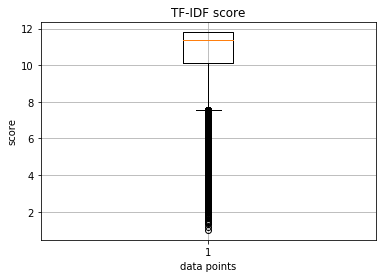

In [19]:
import matplotlib.pyplot as plt
plt.boxplot([score])
plt.title('TF-IDF score')
plt.xlabel('data points')
plt.ylabel('score')
plt.grid()
plt.show()

### based on the above box plot low tf-idf value is 10 and high tf-idf value is 12

## Removing words which have very high or very low TF-IDF values

In [20]:
remove_words=[]
for i in range(109248):
    total_words=(data['total_text'][i])
    wordList = re.sub("[^\w]", " ",  total_words).split()
    for j in wordList:
        try:
            idf = word2tfidf[j]
        except:
            idf = 0
        if(idf>10 and idf <12):
            continue;
        else:
            remove_words.append(j)
    

In [21]:
remove_words=list(set(remove_words))

In [27]:
#code copied from ---https://stackoverflow.com/questions/45447848/check-for-words-from-list-and-remove-those-words-in-pandas-dataframe-column
remove= r'\b(?:{})\b'.format('|'.join(remove_words))
train['total_text'] = train['total_text'].str.replace(remove, '')
test['total_text'] = test['total_text'].str.replace(remove, '')

In [35]:
token = Tokenizer()

token.fit_on_texts(train['total_text'])
train['total_text']=token.texts_to_sequences(train['total_text'])
test['total_text']=token.texts_to_sequences(test['total_text'])
text_size = len(token.word_index) + 1

## Getting data in the form of Dictionary which then will be given as a input to Deep Learning Models

In [37]:
X_train={}

X_train["posted_projects"]= array(train["teacher_number_of_previously_posted_projects"]).reshape(len(train),1)
X_train["price"]= array(train["price"]).reshape(len(train),1)
X_train["quantity"]= array(train["quantity"]).reshape(len(train),1)
X_train["Is_digit_present"]= array(train["Is_digit_present"]).reshape(len(train),1)
        
X_train["teacher_prefix"]= pad_sequences(train["teacher_prefix"], maxlen=1)
X_train["school_state"]= pad_sequences(train["school_state"], maxlen=1)
X_train["project_grade_category"]= pad_sequences(train["project_grade_category"], maxlen=3)
        
X_train["total_text"]= pad_sequences(train["total_text"], maxlen=300)
X_train["clean_categories"]= pad_sequences(train["clean_categories"], maxlen=4)
X_train["clean_subcategories"]= pad_sequences(train["clean_subcategories"], maxlen=4)

X_train["output"]= array(train["project_is_approved"])

In [38]:
X_test={}

X_test["posted_projects"]= array(test["teacher_number_of_previously_posted_projects"]).reshape(len(test),1)
X_test["price"]= array(test["price"]).reshape(len(test),1)
X_test["quantity"]= array(test["quantity"]).reshape(len(test),1)
X_test["Is_digit_present"]= array(test["Is_digit_present"]).reshape(len(test),1)
        
X_test["teacher_prefix"]= pad_sequences(test["teacher_prefix"], maxlen=1)
X_test["school_state"]= pad_sequences(test["school_state"], maxlen=1)
X_test["project_grade_category"]= pad_sequences(test["project_grade_category"], maxlen=3)
        
X_test["total_text"]= pad_sequences(test["total_text"], maxlen=300)
X_test["clean_categories"]= pad_sequences(test["clean_categories"], maxlen=4)
X_test["clean_subcategories"]= pad_sequences(test["clean_subcategories"], maxlen=4)

X_test["output"]= array(test["project_is_approved"])

In [40]:
import keras
    # Input layers
previously_posted_projects = Input(shape=(1,), name="posted_projects")
price = Input(shape=(1,), name="price")
digit_present = Input(shape=(1,), name="Is_digit_present")
quantity = Input(shape=(1,), name="quantity")
    
    
school_state = Input(shape=(1,), name="school_state")
teacher_prefix = Input(shape=(1,), name="teacher_prefix")
project_grade= Input(shape=(3,), name="project_grade_category")
    
total_text = Input(shape=(300,), name="total_text")
clean_categories = Input(shape=(4,), name="clean_categories")
clean_subcategories = Input(shape=(4,), name="clean_subcategories")
    
    # Batch normalization layer
#previously_posted_projects_bn = BatchNormalization(axis=1, momentum=0.99, epsilon=0.001, center=True, scale=True, beta_initializer='zeros', gamma_initializer='ones', moving_mean_initializer='zeros', moving_variance_initializer='ones')(previously_posted_projects)
#price_bn = BatchNormalization(axis=1, momentum=0.99, epsilon=0.001, center=True, scale=True, beta_initializer='zeros', gamma_initializer='ones', moving_mean_initializer='zeros', moving_variance_initializer='ones')(price)
#quantity_bn = BatchNormalization(axis=1, momentum=0.99, epsilon=0.001, center=True, scale=True, beta_initializer='zeros', gamma_initializer='ones', moving_mean_initializer='zeros', moving_variance_initializer='ones')(quantity)
    
    
    
    # Embedding layers
emb_text_layer = Embedding(text_size, 300, weights=[embedding_matrix],  trainable=False)
emb_category_layer = Embedding(category_size, 4)
emb_subcategory_layer = Embedding(subcategory_size, 4)
    
emb_state_layer = Embedding(state_size, 8)
emb_prefix_layer = Embedding(prefix_size, 2)
emb_grade_layer = Embedding(grade_size, 2)
    
    # Giving Input to Embedding layers
emb_text = emb_text_layer(total_text)
emb_category =emb_category_layer(clean_categories)
emb_subcategory =emb_subcategory_layer(clean_subcategories)
    
emb_state =emb_state_layer(school_state)
emb_prefix =emb_prefix_layer(teacher_prefix)
emb_grade =emb_grade_layer(project_grade)
    
        
    # LSTM layers
lstm_text = LSTM(12, activation="relu", return_sequences=True)(emb_text)
    
    # Flatten layers
flatten_text =Flatten()(lstm_text)
flatten_category =Flatten()(emb_category)
flatten_subcategory =keras.layers.Flatten()(emb_subcategory)
    
flatten_state =Flatten()(emb_state)
flatten_prefix =Flatten()(emb_prefix)
flatten_grade =Flatten()(emb_grade)
    
    # concatenation of all numeric layers
numeric= concatenate([previously_posted_projects,
                                      price,
                                      digit_present,
                                      quantity])
    # Dense layer
dense_numeric =Dense(4, activation='relu',kernel_initializer=he_normal(seed=5))(numeric)
    
    # Merge all layers into one
x = concatenate([dense_numeric,
                                 flatten_text,
                                 flatten_category,
                                 flatten_subcategory,
                                 flatten_state,
                                 flatten_prefix,
                                 flatten_grade])
    
dense_x =Dense(8, activation='relu',kernel_initializer=he_normal(seed=3))(x)
    
dense_x_bn= BatchNormalization(axis=1, momentum=0.99, epsilon=0.001, center=True, scale=True, beta_initializer='zeros', gamma_initializer='ones', moving_mean_initializer='zeros', moving_variance_initializer='ones')(dense_x)
    
#drop_x =Dropout(0.5)(dense_x_bn)
    
dense2_x =Dense(4, activation='relu',kernel_initializer=he_normal(seed=1))(dense_x_bn)
    
#drop2_x =Dropout(0.5)(dense2_x)
    
dense3_x =Dense(2, activation='relu',kernel_initializer=he_normal(seed=2))(dense2_x)
    
    # Dense layers
    #x = keras.layers.Dense(128, activation="relu")(x)

    # Output layers
output = Dense(1, activation="sigmoid", name='final_output')(dense3_x)
    


model = Model(inputs=[previously_posted_projects,price,digit_present,quantity,school_state,teacher_prefix,project_grade,total_text,clean_categories,clean_subcategories], outputs=[output])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
total_text (InputLayer)         (None, 300)          0                                            
__________________________________________________________________________________________________
posted_projects (InputLayer)    (None, 1)            0                                            
__________________________________________________________________________________________________
price (InputLayer)              (None, 1)            0                                            
__________________________________________________________________________________________________
Is_digit_present (InputLayer)   (None, 1)            0                                            
__________________________________________________________________________________________________
quantity (

## Running Model 1 but with words removed based on their TF-IDF values

In [41]:


tb =TensorBoard(log_dir="logs2/{}".format(time()))

model.compile(optimizer = Adam(lr=1e-3),
                  loss={'final_output': 'binary_crossentropy'},
                  metrics=[roc_auc])




model.fit({"posted_projects":X_train['posted_projects'], "price":X_train['price'],
              "Is_digit_present":X_train['Is_digit_present'], "quantity":X_train['quantity'],
              "school_state":X_train['school_state'], "teacher_prefix":X_train['teacher_prefix'],
        "project_grade_category":X_train['project_grade_category'], "total_text":X_train['total_text'],
        "clean_categories":X_train['clean_categories'], "clean_subcategories":X_train['clean_subcategories']}
              ,{
              "final_output":X_train['output']},
                 batch_size=2500,
                epochs=40,
              
               validation_data=({"posted_projects":X_test['posted_projects'], "price":X_test['price'],
              "Is_digit_present":X_test['Is_digit_present'], "quantity":X_test['quantity'],
              "school_state":X_test['school_state'], "teacher_prefix":X_test['teacher_prefix'],
        "project_grade_category":X_test['project_grade_category'], "total_text":X_test['total_text'],
        "clean_categories":X_test['clean_categories'], "clean_subcategories":X_test['clean_subcategories']}
              ,{
              "final_output":X_test['output']}),
                callbacks=[tb])

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Instructions for updating:
Use tf.cast instead.
Train on 98323 samples, validate on 10925 samples
Epoch 1/40
98323/98323 [==============================] - 36s 362us/step - loss: 0.6599 - roc_auc: 0.4565 - val_loss: 0.6201 - val_roc_auc: 0.4675
Epoch 2/40
98323/98323 [==============================] - 33s 333us/step - loss: 0.5860 - roc_auc: 0.4874 - val_loss: 0.5089 - val_roc_auc: 0.5061
Epoch 3/40
98323/98323 [==============================] - 33s 337us/step - loss: 0.5117 - roc_auc: 0.5199 - val_loss: 0.4726 - val_roc_auc: 0.5307
Epoch 4/40
98323/98323 [==============================] - 33s 336us/step - loss: 0.4589 - roc_auc: 0.5406 - val_loss: 0.4307 - val_roc_auc: 0.5484
Epoch 5/40
98323/98323 [==============================] - 33s 335us/step - loss: 0.4236 - roc_auc: 0.5563 - val_loss: 0.4505 - val_roc_auc: 0.5630
Epoch 6/40
98323/98323 [=================

## Saving my neural network model to JSON

In [42]:


# serialize model to JSON
model_json = model.to_json()
with open("model_reduce_words.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model_reduce_words.h5")

## One Hot encoding categorical data using keras preprocessing

In [38]:
train['teacher_prefix'] = train['teacher_prefix'].map(lambda a:keras.preprocessing.text.one_hot(a,100))
train['school_state'] = train['school_state'].map(lambda a:keras.preprocessing.text.one_hot(a,100))
train['project_grade_category'] = train['project_grade_category'].map(lambda a:keras.preprocessing.text.one_hot(a,100))
train['clean_categories'] = train['clean_categories'].map(lambda a:keras.preprocessing.text.one_hot(a,100))
train['clean_subcategories'] = train['clean_subcategories'].map(lambda a:keras.preprocessing.text.one_hot(a,100))

In [35]:
test['teacher_prefix'] = test['teacher_prefix'].map(lambda a:keras.preprocessing.text.one_hot(a,100))
test['school_state'] = test['school_state'].map(lambda a:keras.preprocessing.text.one_hot(a,100))
test['project_grade_category'] = test['project_grade_category'].map(lambda a:keras.preprocessing.text.one_hot(a,100))
test['clean_categories'] = test['clean_categories'].map(lambda a:keras.preprocessing.text.one_hot(a,100))
test['clean_subcategories'] = test['clean_subcategories'].map(lambda a:keras.preprocessing.text.one_hot(a,100))

## Getting data in the form of Dictionary which then will be given as a input to Deep Learning Models

In [16]:
X_train={} 

X_train["posted_projects"]= array(train["teacher_number_of_previously_posted_projects"]).reshape(len(train),1)
X_train["price"]= array(train["price"]).reshape(len(train),1)
X_train["quantity"]= array(train["quantity"]).reshape(len(train),1)
X_train["Is_digit_present"]= array(train["Is_digit_present"]).reshape(len(train),1)
        
X_train["teacher_prefix"]= pad_sequences(train["teacher_prefix"], maxlen=4)
X_train["school_state"]= pad_sequences(train["school_state"], maxlen=4)
X_train["project_grade_category"]= pad_sequences(train["project_grade_category"], maxlen=4)
        
X_train["total_text"]= pad_sequences(train["total_text"], maxlen=300)
X_train["clean_categories"]= pad_sequences(train["clean_categories"], maxlen=4)
X_train["clean_subcategories"]= pad_sequences(train["clean_subcategories"], maxlen=4)

X_train["output"]= array(train["project_is_approved"])

In [17]:
X_test={}

X_test["posted_projects"]= array(test["teacher_number_of_previously_posted_projects"]).reshape(len(test),1)
X_test["price"]= array(test["price"]).reshape(len(test),1)
X_test["quantity"]= array(test["quantity"]).reshape(len(test),1)
X_test["Is_digit_present"]= array(test["Is_digit_present"]).reshape(len(test),1)
        
X_test["teacher_prefix"]= pad_sequences(test["teacher_prefix"], maxlen=4)
X_test["school_state"]= pad_sequences(test["school_state"], maxlen=4)
X_test["project_grade_category"]= pad_sequences(test["project_grade_category"], maxlen=4)
        
X_test["total_text"]= pad_sequences(test["total_text"], maxlen=300)
X_test["clean_categories"]= pad_sequences(test["clean_categories"], maxlen=4)
X_test["clean_subcategories"]= pad_sequences(test["clean_subcategories"], maxlen=4)

X_test["output"]= array(test["project_is_approved"])

## Model 2

In [18]:
from keras.layers.core import Reshape
from keras.layers import Conv1D

In [28]:
import keras
    # Input layers
previously_posted_projects = Input(shape=(1,), name="posted_projects")
price = Input(shape=(1,), name="price")
digit_present = Input(shape=(1,), name="Is_digit_present")
quantity = Input(shape=(1,), name="quantity")
    
    
school_state = Input(shape=(4,), name="school_state")
teacher_prefix = Input(shape=(4,), name="teacher_prefix")
project_grade= Input(shape=(4,), name="project_grade_category")
    
total_text = Input(shape=(300,), name="total_text")
clean_categories = Input(shape=(4,), name="clean_categories")
clean_subcategories = Input(shape=(4,), name="clean_subcategories")
       
    # Embedding layers
emb_text_layer = Embedding(text_size, 300, weights=[embedding_matrix], trainable=False)
    
    
    # Giving Input to Embedding layers
emb_text = emb_text_layer(total_text)
            
    # LSTM layers
lstm_text = LSTM(14, activation="relu", return_sequences=True)(emb_text)
    
    # Flatten layers
flatten_text = Flatten()(lstm_text)
    
    
    # concatenation of all numeric and categorical layers
other= concatenate([ 
                                      school_state,
                                      teacher_prefix,
                                      project_grade,
                                      clean_categories,
                                      clean_subcategories])
    # Dense layer
new= Reshape([4,-1])(other)
    
    # cnn layer
cnn_1= Conv1D(12,1, activation='relu')(new)
    
cnn_2= Conv1D(24, 3, activation='relu')(cnn_1)
    
    # Flatten layer
flatten_cnn_2= Flatten()(cnn_2)
    
     # Batch normalization layer
#previously_posted_projects_bn = BatchNormalization(axis=1, momentum=0.99, epsilon=0.001, center=True, scale=True, beta_initializer='zeros', gamma_initializer='ones', moving_mean_initializer='zeros', moving_variance_initializer='ones')(previously_posted_projects)
#price_bn= BatchNormalization(axis=1, momentum=0.99, epsilon=0.001, center=True, scale=True, beta_initializer='zeros', gamma_initializer='ones', moving_mean_initializer='zeros', moving_variance_initializer='ones')(price)
#quantity_bn = BatchNormalization(axis=1, momentum=0.99, epsilon=0.001, center=True, scale=True, beta_initializer='zeros', gamma_initializer='ones', moving_mean_initializer='zeros', moving_variance_initializer='ones')(quantity)
    
    
    # Merge all layers into one
x = concatenate([flatten_text, flatten_cnn_2,previously_posted_projects,
                                 price,
                                 quantity,
                                 digit_present])
    
dense_x = Dense(8, activation='relu',kernel_initializer=he_normal(seed=None))(x)
    
dense_x_bn= keras.layers.BatchNormalization(axis=1, momentum=0.99, epsilon=0.001, center=True, scale=True, beta_initializer='zeros', gamma_initializer='ones', moving_mean_initializer='zeros', moving_variance_initializer='ones')(dense_x)
    
#drop_x = Dropout(0.5)(dense_x_bn)
    
dense2_x = Dense(4, activation='relu',kernel_initializer=he_normal(seed=None))(dense_x_bn)
    
#drop2_x = Dropout(0.5)(dense2_x)
    
dense3_x = Dense(2, activation='relu',kernel_initializer=he_normal(seed=None))(dense2_x)
    
    # Dense layers
    #x = keras.layers.Dense(128, activation="relu")(x)

    # Output layers
output = Dense(1, activation="sigmoid", name="final_output")(dense3_x)
    


model = Model(inputs=[previously_posted_projects,price,digit_present,quantity,school_state,teacher_prefix,project_grade,total_text,clean_categories,clean_subcategories], outputs=[output])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
school_state (InputLayer)       (None, 4)            0                                            
__________________________________________________________________________________________________
teacher_prefix (InputLayer)     (None, 4)            0                                            
__________________________________________________________________________________________________
project_grade_category (InputLa (None, 4)            0                                            
__________________________________________________________________________________________________
clean_categories (InputLayer)   (None, 4)            0                                            
__________________________________________________________________________________________________
clean_subc

In [29]:


tb =TensorBoard(log_dir="logs3/{}".format(time()))

model.compile(optimizer= Adam(lr=1e-2),
                  loss={'final_output': 'binary_crossentropy'},
                  metrics=[roc_auc])




model.fit({"posted_projects":X_train['posted_projects'], "price":X_train['price'],
              "Is_digit_present":X_train['Is_digit_present'], "quantity":X_train['quantity'],
              "school_state":X_train['school_state'], "teacher_prefix":X_train['teacher_prefix'],
        "project_grade_category":X_train['project_grade_category'], "total_text":X_train['total_text'],
        "clean_categories":X_train['clean_categories'], "clean_subcategories":X_train['clean_subcategories']}
              ,{
              "final_output":X_train['output']},
                 batch_size=2500,
                epochs=40,
              
               validation_data=({"posted_projects":X_test['posted_projects'], "price":X_test['price'],
              "Is_digit_present":X_test['Is_digit_present'], "quantity":X_test['quantity'],
              "school_state":X_test['school_state'], "teacher_prefix":X_test['teacher_prefix'],
        "project_grade_category":X_test['project_grade_category'], "total_text":X_test['total_text'],
        "clean_categories":X_test['clean_categories'], "clean_subcategories":X_test['clean_subcategories']}
              ,{
              "final_output":X_test['output']}),
                callbacks=[tb])

Train on 98323 samples, validate on 10925 samples
Epoch 1/40
98323/98323 [==============================] - 36s 371us/step - loss: 0.4426 - roc_auc: 0.5899 - val_loss: 0.4213 - val_roc_auc: 0.6301
Epoch 2/40
98323/98323 [==============================] - 34s 341us/step - loss: 0.3742 - roc_auc: 0.6606 - val_loss: 0.3895 - val_roc_auc: 0.6835
Epoch 3/40
98323/98323 [==============================] - 34s 341us/step - loss: 0.3647 - roc_auc: 0.6986 - val_loss: 0.3843 - val_roc_auc: 0.7091
Epoch 4/40
98323/98323 [==============================] - 34s 342us/step - loss: 0.3570 - roc_auc: 0.7185 - val_loss: 0.4054 - val_roc_auc: 0.7250
Epoch 5/40
98323/98323 [==============================] - 34s 342us/step - loss: 0.3504 - roc_auc: 0.7317 - val_loss: 0.3895 - val_roc_auc: 0.7371
Epoch 6/40
98323/98323 [==============================] - 34s 341us/step - loss: 0.3401 - roc_auc: 0.7435 - val_loss: 0.3904 - val_roc_auc: 0.7484
Epoch 7/40
98323/98323 [==============================] - 34s 341us/

## Saving my neural network model to JSON

In [31]:


# serialize model to JSON
model_json = model.to_json()
with open("model_conv1.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model_conv1.h5")

## Result

In [15]:
#code copied from -http://zetcode.com/python/prettytable/
from prettytable import PrettyTable   
x = PrettyTable()
x.field_names = ["Model no.", "train auc", "test auc"]
x.add_row(["Model 1", 0.7052 ,0.7055])
x.add_row(["Model 1 with reduced words", 0.7599, 0.7610])
x.add_row(["Model 2", 0.8784 ,0.8790])

print(x)

+----------------------------+-----------+----------+
|         Model no.          | train auc | test auc |
+----------------------------+-----------+----------+
|          Model 1           |   0.7052  |  0.7055  |
| Model 1 with reduced words |   0.7599  |  0.761   |
|          Model 2           |   0.8784  |  0.879   |
+----------------------------+-----------+----------+
